In [1]:
!pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 4.3 MB/s eta 0:00:00


In [17]:
!pip install JPype1-py3 -y

Found existing installation: JPype1-py3 0.5.5.4
Uninstalling JPype1-py3-0.5.5.4:
  Successfully uninstalled JPype1-py3-0.5.5.4


In [15]:
!pip install konlpy -y

Found existing installation: konlpy 0.6.0
Uninstalling konlpy-0.6.0:
  Successfully uninstalled konlpy-0.6.0


In [ ]:
# konlpy를 사용하려면 java와 python의 버전을 맞춰줘야한다.

In [4]:
import pandas as pd
import numpy as np

from collections import Counter
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# 데이터 로드

In [5]:
import pandas as pd
import numpy as np

data = pd.read_csv('data/reviewdata.csv')
review=data['review']
print(review)

0        커피 마실때 빨대로 먹는게 좋다고해서 빨대 텀블러로 했는데 너무 좋아용 배송도 빠르...
1        한달사용기아침에   학원 갈때  얼음과 음료수를 함께 넣어 가는데 저녁까지도  얼음...
2        디자인 성능 등은 다 좋은데 다른 텀블러는 박스에 제대로 포장되어있는 반면 이 텀블...
3        여러가지 텀블러 써봤는데 퀄리티가 진짜 좋아요. 굉장히 만족스러운 텀블러입니다. 색...
4        여러가지 텀블러 써봤는데 퀄리티가 진짜 좋아요. 굉장히 만족스러운 텀블러입니다. 색...
                               ...                        
31245                                              좋아요😍😍😍😍
31246                                                    굳
31247                                                  좋아요
31248                                                  좋네요
31249                                                   좋응
Name: review, Length: 31250, dtype: object


# EDA

## 결측치 제거
- 결측치를 제대로 제거하지 않으면 형태소 분리기가 제대로 작동하지 않을 수 있다 (특히kkm)

In [6]:
# 한글 제외하고 삭제 (정규표현식으로)
data["review"] = data["review"].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
review=data["review"]
reviewList = []
for i in review:
    reviewList.append(i)

/var/folders/d0/hsqd9x956qgdv8tn9cts8vmc0000gn/T/ipykernel_26399/2413480644.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  data["review"] = data["review"].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


In [7]:
# null값 제거
review.dropna(inplace=True)

# 중복 제거
review=review.unique()
len(review)

28635

In [8]:
review

array(['커피 마실때 빨대로 먹는게 좋다고해서 빨대 텀블러로 했는데 너무 좋아용 배송도 빠르고요 스탠리 제품은 보온 보냉은 워낙 잘 되고 믿을만해서 말할것도 없습니다',
       '한달사용기아침에   학원 갈때  얼음과 음료수를 함께 넣어 가는데 저녁까지도  얼음이   녹지 않아 시원하게  먹을 수 있어 넘 좋다네요 불리해서 세척도 가능하고 가성비가 있어도 또 구매하려고요  ',
       '디자인 성능 등은 다 좋은데 다른 텀블러는 박스에 제대로 포장되어있는 반면 이 텀블러는 그냥 종이랑 뽁뽁이로만 둘러져있네요 왜 그런걸까요 찝찝해서 별 두개 뺐어요',
       ..., '굿군', '굿드로', '강력추천'], dtype=object)

## 형태소 분리
- morphs(text): 텍스트에서 형태소를 반환
- nouns(text): 텍스트에서 명사를 반환
- phrases(text): 텍스트에서 어절을 추출
- pos(text): 텍스트에서 품사정보를 부착하여 반환

#### 형태소 분리기는 Okt 사용
프로젝트 수행 당시에는 window에서 사용했는데 지금은 m1 macOS 여서 잘 작동하지 않는다. 다른 대안을 고려해볼 필요가 있다.
- kiwipiepy: C++ 구현체에 파이썬을 래핑한 분석기입니다. M1에서 문제없이 동작합니다. 속도도 konlpy급으로 빠릅니다.
- pynori: 엘러스틱서치 검색엔진의 공식 한국어 형태소 분석기로 유명한 nori의 순수 파이썬 포트입니다. M1에서 문제없이 동작합니다.
- pecab: nori만큼 유명한 mecab의 순수 파이썬 포트입니다. M1에서 동작합니다.

In [ ]:
from konlpy.tag import Okt
from tqdm import tqdm

# 리뷰를 형태소 분리기에 넣기 좋게 가공
reviewList = []
for i in review:
    reviewList.append(i)

okt = Okt() # 분리기 생성

df3 = pd.DataFrame([["",""]], columns=["형태소","품사"]) # 분리해서 담을 데이터 프레임 생성

for i in tqdm(reviewList):
    rs = okt.pos(i) # 품사 부착
    df = pd.DataFrame(rs, columns=["형태소", "품사"]) # 데이터 프레임으로 형성
    df2 = df[(df['품사']=='Noun') | (df['품사']=='Adjective') | (df['품사']=='Verb')] # 불리언색인으로 원하는 품사만 추출
    df3 = pd.concat([df3, df2])

In [8]:
df3

형태소         품사
0                 
0    커피       Noun
1    마실       Verb
2     때       Noun
3    빨대       Noun
..  ...        ...
1   좋아여  Adjective
0     굿       Noun
0    굿드       Noun
0    강력       Noun
1    추천       Noun

[283834 rows x 2 columns]

In [9]:
dfN = df3[df3['품사']=='Noun']
dfAd = df3[df3['품사']=='Adjective']
dfV = df3[df3['품사']=='Verb']

# 단어 빈도 분석 

In [10]:
counterN = Counter(dfN['형태소'])
counterN.most_common(50)

[('물', 6202),
 ('사용', 4907),
 ('달', 4077),
 ('배송', 2536),
 ('세척', 2178),
 ('생각', 2058),
 ('때', 1840),
 ('구매', 1817),
 ('디자인', 1733),
 ('용기', 1462),
 ('아주', 1456),
 ('용량', 1420),
 ('더', 1284),
 ('리터', 1275),
 ('하루', 1273),
 ('제품', 1253),
 ('보온', 1235),
 ('것', 1199),
 ('텀블러', 1195),
 ('물통', 1189),
 ('맘', 1134),
 ('손잡이', 1132),
 ('커서', 1111),
 ('좀', 1098),
 ('뚜껑', 1079),
 ('얼음', 1078),
 ('스탠리', 1061),
 ('크기', 1023),
 ('입구', 973),
 ('보냉', 950),
 ('정말', 943),
 ('거', 909),
 ('운동', 884),
 ('사이즈', 882),
 ('마음', 857),
 ('수', 842),
 ('손', 841),
 ('마시기', 783),
 ('기능', 729),
 ('선물', 716),
 ('진짜', 712),
 ('부분', 658),
 ('조금', 654),
 ('빨대', 645),
 ('하나', 608),
 ('시간', 590),
 ('안', 586),
 ('알람', 583),
 ('완전', 554),
 ('물이', 547)]

In [11]:
counterAd = Counter(dfAd['형태소'])
counterAd.most_common(50)

[('좋아요', 6615),
 ('좋네요', 1960),
 ('좋습니다', 1914),
 ('같아요', 1531),
 ('입니다', 1342),
 ('편하고', 1094),
 ('만족합니다', 1088),
 ('좋은', 1074),
 ('좋고', 1014),
 ('빠르고', 965),
 ('있어서', 868),
 ('가볍고', 772),
 ('편해요', 722),
 ('있어요', 636),
 ('튼튼하고', 630),
 ('있습니다', 551),
 ('빠른', 469),
 ('좋', 408),
 ('이쁘고', 402),
 ('편해서', 362),
 ('예쁘고', 338),
 ('있어', 336),
 ('같습니다', 327),
 ('좋은데', 326),
 ('좋아서', 317),
 ('이뻐요', 293),
 ('있는', 283),
 ('넓어서', 268),
 ('깔끔하고', 261),
 ('예뻐요', 256),
 ('편합니다', 251),
 ('좋음', 241),
 ('뜨거운', 239),
 ('확실히', 238),
 ('좋아', 230),
 ('굳', 227),
 ('만족해요', 217),
 ('편하네요', 212),
 ('같네요', 206),
 ('같은', 202),
 ('있고', 195),
 ('좋아용', 192),
 ('조아요', 185),
 ('괜찮아요', 181),
 ('편하게', 179),
 ('없어서', 178),
 ('만족스럽습니다', 173),
 ('작은', 172),
 ('있는데', 164),
 ('있네요', 162)]

In [12]:
counterV = Counter(dfV['형태소'])
counterV.most_common(50)

[('잘', 2596),
 ('재구매', 1247),
 ('할', 1180),
 ('했는데', 1073),
 ('하기', 984),
 ('크고', 861),
 ('들어요', 830),
 ('합니다', 795),
 ('했어요', 749),
 ('들고', 717),
 ('해서', 708),
 ('감사합니다', 655),
 ('큰', 567),
 ('마시게', 563),
 ('넘', 549),
 ('샀는데', 544),
 ('되네요', 532),
 ('마시는', 500),
 ('쓰고', 477),
 ('그립', 448),
 ('써', 428),
 ('되고', 404),
 ('마실', 395),
 ('했습니다', 394),
 ('않고', 376),
 ('샀어요', 363),
 ('크네요', 339),
 ('먹게', 328),
 ('챙겨', 328),
 ('먹는', 295),
 ('하는', 293),
 ('들어가서', 292),
 ('믿고', 289),
 ('보니', 289),
 ('하기도', 285),
 ('마시고', 284),
 ('받았습니다', 272),
 ('하네요', 267),
 ('커요', 261),
 ('됩니다', 260),
 ('되서', 252),
 ('들', 251),
 ('하면서', 249),
 ('파세요', 244),
 ('넣고', 239),
 ('하세요', 228),
 ('씻기', 228),
 ('마시는데', 211),
 ('먹을', 203),
 ('쓰는', 202)]

# 워드 클라우드

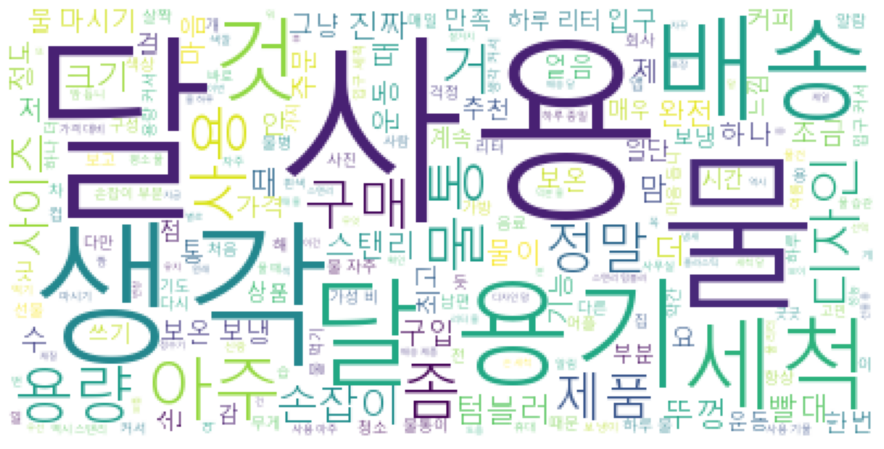

In [13]:
wc = WordCloud(background_color="white", 
               font_path="C:\Windows\Fonts\malgunsl.ttf")
cloud_rs = wc.generate_from_text(" ".join(dfN['형태소']))
plt.figure(figsize=(20,8))
plt.imshow(cloud_rs)
plt.axis("off") # x축,y축 끄기
plt.show()

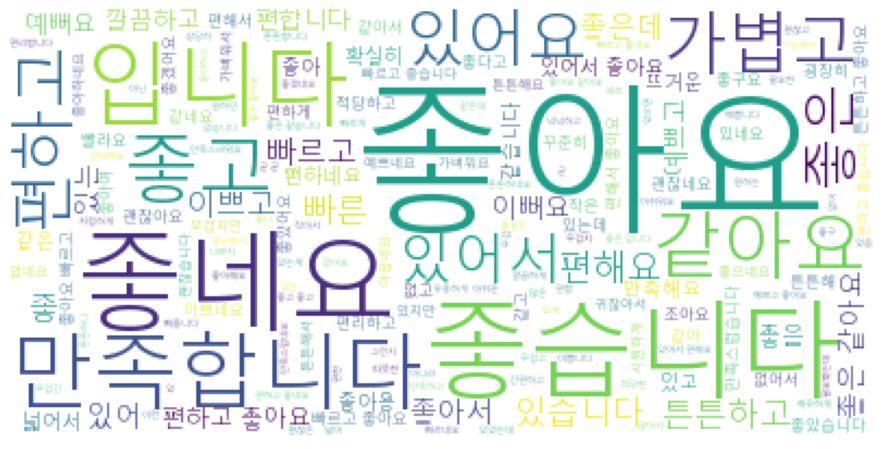

In [14]:
wc = WordCloud(background_color="white", 
               font_path="C:\Windows\Fonts\malgunsl.ttf")
cloud_rs = wc.generate_from_text(" ".join(dfAd['형태소']))
plt.figure(figsize=(20,8))
plt.imshow(cloud_rs)
plt.axis("off") # x축,y축 끄기
plt.show()

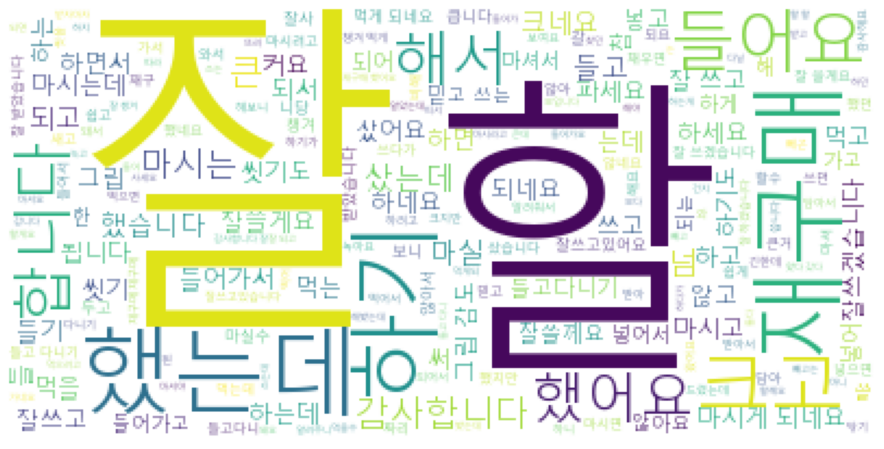

In [15]:
wc = WordCloud(background_color="white", 
               font_path="C:\Windows\Fonts\malgunsl.ttf")
cloud_rs = wc.generate_from_text(" ".join(dfV['형태소']))
plt.figure(figsize=(20,8))
plt.imshow(cloud_rs)
plt.axis("off") # x축,y축 끄기
plt.show()

# TFiDF
- 벡터라이저는 말뭉치를 리스트 형태로, 문서를 요소 형태로 

In [16]:
#사용자 정의 함수로 된거 그대로 적용하고 ()안에 하이퍼 파라미터 넣어서 조정할 수 있음
# 사용자 정의 tokenizer 함수 정의
def myTokenizer(text):
    rs = okt.pos(text) #품사 부착
    df = pd.DataFrame(rs, columns=["형태소", "품사"])
    #불리언색인
    df2 = df[(df['품사']=='Noun') | (df['품사']=='Adjective') | (df['품사']=='Verb')]
    return df2['형태소'] 

In [47]:
tfidf = TfidfVectorizer(tokenizer=myTokenizer, 
                        stop_words=['물', '좋아요', '좋네요', '좋습니다', '잘', '할', '달', '때', '생각', '아주', '입니다', '했는데', '했어요', '하기', '합니다', '같아요'],
                       ) 
tfidf.fit(reviewList)

C:\Users\AI\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


TfidfVectorizer(stop_words=['물', '좋아요', '좋네요', '좋습니다', '잘', '할', '달', '때', '생각',
                            '아주', '입니다', '했는데', '했어요', '하기', '합니다', '같아요'],
                tokenizer=<function myTokenizer at 0x000001C7DC3923A0>)

In [48]:
tfidf.vocabulary_

{'커피': 18986,
 '마실': 6945,
 '빨대': 10205,
 '먹는게': 7681,
 '좋다고': 17111,
 '해서': 20968,
 '텀블러': 19420,
 '좋아용': 17180,
 '배송': 8995,
 '빠르고요': 10123,
 '스탠리': 11626,
 '제품': 16835,
 '보온': 9441,
 '보냉': 9344,
 '워낙': 14942,
 '되고': 5077,
 '믿을': 8574,
 '만해': 7287,
 '말': 7351,
 '할것도': 20693,
 '없습니다': 13887,
 '사용': 10539,
 '아침': 12909,
 '학원': 20624,
 '갈': 417,
 '얼음': 13783,
 '음료수': 15174,
 '넣어': 3296,
 '가는데': 45,
 '저녁': 16508,
 '녹지': 3492,
 '않아': 13165,
 '시원하게': 11770,
 '먹을': 7793,
 '수': 11410,
 '있어': 15862,
 '넘': 3217,
 '좋다네요': 17116,
 '불리해서': 9832,
 '세척': 11277,
 '가능하고': 60,
 '가성': 208,
 '비': 9998,
 '있어도': 15863,
 '또': 6262,
 '구매': 1556,
 '하려고요': 20463,
 '디자인': 5926,
 '성능': 11201,
 '등': 5908,
 '좋은데': 17353,
 '다른': 4073,
 '박스': 8737,
 '제대로': 16813,
 '포장': 20079,
 '되어있는': 5169,
 '반면': 8778,
 '이': 15219,
 '그냥': 1741,
 '종이': 17028,
 '뽁뽁이로': 10313,
 '둘러져있네요': 5383,
 '왜': 14576,
 '걸': 989,
 '까요': 2239,
 '찝찝해서': 18184,
 '별': 9225,
 '개': 751,
 '뺐어요': 10290,
 '여러가지': 14034,
 '써': 12183,
 '봤는데': 9603,
 '퀄리티':

In [49]:
#중요!!!!
#딕셔너리 형태의 사전 인덱스 기준 정렬 하기
nsvoca = tfidf.vocabulary_
svoca = sorted(nsvoca.items())
svoca

[('가', 0),
 ('가거나', 1),
 ('가게', 2),
 ('가겟어', 3),
 ('가겟쬬', 4),
 ('가겠죠', 5),
 ('가겠지요', 6),
 ('가격', 7),
 ('가고', 8),
 ('가고싶어여', 9),
 ('가고싶어요', 10),
 ('가고요', 11),
 ('가구', 12),
 ('가군', 13),
 ('가기', 14),
 ('가기기', 15),
 ('가기전에', 16),
 ('가긴', 17),
 ('가길', 18),
 ('가까운', 19),
 ('가까운거', 20),
 ('가까워서', 21),
 ('가까워지고', 22),
 ('가까웠었는데', 23),
 ('가까이', 24),
 ('가깝게', 25),
 ('가깝네요', 26),
 ('가깝지만', 27),
 ('가꾸는', 28),
 ('가꿀', 29),
 ('가끔', 30),
 ('가나', 31),
 ('가나다', 32),
 ('가네', 33),
 ('가네여', 34),
 ('가네요', 35),
 ('가네용', 36),
 ('가눈', 37),
 ('가는', 38),
 ('가는거', 39),
 ('가는거라고', 40),
 ('가는거예요', 41),
 ('가는건', 42),
 ('가는것', 43),
 ('가는것을', 44),
 ('가는데', 45),
 ('가는데도', 46),
 ('가는데이건', 47),
 ('가는듯', 48),
 ('가는줄', 49),
 ('가는지', 50),
 ('가늘어서', 51),
 ('가늠', 52),
 ('가능', 53),
 ('가능성', 54),
 ('가능하', 55),
 ('가능하거든요', 56),
 ('가능하게', 57),
 ('가능하겠네요', 58),
 ('가능하겠어요', 59),
 ('가능하고', 60),
 ('가능하고요', 61),
 ('가능하구', 62),
 ('가능하긴', 63),
 ('가능하나', 64),
 ('가능하네요', 65),
 ('가능하니', 66),
 ('가능하니까', 67),
 ('가능하다길래', 68),
 ('가능하다는거', 69

In [50]:
#딕셔너리 키값 출력
vocaList = []
for key, value in svoca:
    vocaList.append(key)
vocaList

['가',
 '가거나',
 '가게',
 '가겟어',
 '가겟쬬',
 '가겠죠',
 '가겠지요',
 '가격',
 '가고',
 '가고싶어여',
 '가고싶어요',
 '가고요',
 '가구',
 '가군',
 '가기',
 '가기기',
 '가기전에',
 '가긴',
 '가길',
 '가까운',
 '가까운거',
 '가까워서',
 '가까워지고',
 '가까웠었는데',
 '가까이',
 '가깝게',
 '가깝네요',
 '가깝지만',
 '가꾸는',
 '가꿀',
 '가끔',
 '가나',
 '가나다',
 '가네',
 '가네여',
 '가네요',
 '가네용',
 '가눈',
 '가는',
 '가는거',
 '가는거라고',
 '가는거예요',
 '가는건',
 '가는것',
 '가는것을',
 '가는데',
 '가는데도',
 '가는데이건',
 '가는듯',
 '가는줄',
 '가는지',
 '가늘어서',
 '가늠',
 '가능',
 '가능성',
 '가능하',
 '가능하거든요',
 '가능하게',
 '가능하겠네요',
 '가능하겠어요',
 '가능하고',
 '가능하고요',
 '가능하구',
 '가능하긴',
 '가능하나',
 '가능하네요',
 '가능하니',
 '가능하니까',
 '가능하다길래',
 '가능하다는거',
 '가능하다니',
 '가능하다면',
 '가능하면',
 '가능하여',
 '가능하지만',
 '가능한',
 '가능한가요',
 '가능한거',
 '가능한거겠죠',
 '가능한게',
 '가능한데',
 '가능한지',
 '가능할',
 '가능할거',
 '가능할것',
 '가능할것으로',
 '가능할까',
 '가능함',
 '가능합니다',
 '가능해서',
 '가능해요',
 '가능했습니다',
 '가능했으면',
 '가니',
 '가니까',
 '가니깐',
 '가다',
 '가더',
 '가더라구요',
 '가던',
 '가도',
 '가도되',
 '가두되',
 '가둘거예요',
 '가드',
 '가득',
 '가득체웠',
 '가득하서',
 '가득하시길',
 '가득해서',
 '가득해요',
 '가득해졌어요',
 '가든',
 '가디',
 '가라',
 '가라네요',
 '가

In [51]:
trans = tfidf.transform(reviewList)
toarr=trans.toarray() #희소행렬을 toarray(), todense()로  NumPy 행렬 또는 배열로 변환하여 우리가 볼 수 있도록 가시화 할 수 있음

In [53]:
toarrDF = pd.DataFrame(toarr, columns=vocaList)

rsSe = toarrDF.sum()
rsDF = pd.DataFrame(rsSe, columns=["Vector"])
rsDF

Vector
가            13.225329
가거나           1.069553
가게            6.610350
가겟어           0.332750
가겟쬬           0.280748
가겠죠           0.630954
가겠지요          0.361357
가격          146.748534
가고           47.904683
가고싶어여         0.790326
가고싶어요         0.582292
가고요           1.891921
가구            2.346210
가군            0.334049
가기           13.186394
가기기           0.489220
가기전에          0.325457
가긴            0.527943
가길            0.769941
가까운           1.651146
가까운거          0.406004
가까워서          0.840805
가까워지고         0.476268
가까웠었는데        0.198400
가까이           2.009705
가깝게           0.693393
가깝네요          0.235303
가깝지만          0.605541
가꾸는           0.356028
가꿀            0.599107
가끔            9.207961
가나            4.140375
가나다           1.721754
가네            0.815759
가네여           0.277012
가네요          26.312270
가네용           0.578127
가눈            0.420572
가는           12.447053
가는거           5.024405
가는거라고         0.447208
가는거예요         0.676724
가는건           0.653297
가는것           1.829368
가는것을          0.330416
가는데           3.601054
가는데도          0.198921
가는데이건         0.311432
가는듯           1.657593
가는줄           0.447095
가는지           0.193259
가늘어서          0.834623
가늠            2.429612
가능            6.706770
가능성           0.566394
가능하           0.262557
가능하거든요        0.367870
가능하게          0.557511
가능하겠네요        1.192941
가능하겠어요        0.754432
가능하고          6.652581
가능하고요         0.352367
가능하구          0.360621
가능하긴          0.349429
가능하나          0.205975
가능하네요         2.789914
가능하니          1.773181
가능하니까         0.456122
가능하다길래        0.219348
가능하다는거        0.324157
가능하다니         0.273049
가능하다면         0.691320
가능하면          0.616674
가능하여          0.155809
가능하지만         0.430732
가능한           5.944058
가능한가요         0.276478
가능한거          0.822789
가능한거겠죠        0.199449
가능한게          1.076402
가능한데          0.223163
가능한지          0.045335
가능할           0.478172
가능할거          0.268099
가능할것          0.365993
가능할것으로        0.475758
가능할까          1.697596
가능함           0.763910
가능합니다         2.453331
가능해서         16.016059
가능해요          2.579114
가능했습니다        0.214249
가능했으면         1.941391
가니            2.723209
가니까           0.475708
가니깐           1.041296
가다            0.294498
가더            0.809473
가더라구요         2.562984
가던            0.705163
가도           10.046300
가도되           0.907697
가두되           0.543552
가둘거예요         0.385250
가드            0.157280
가득           29.427347
가득체웠          0.389437
가득하서          0.235322
가득하시길         0.738422
가득해서          0.339776
가득해요          0.765345
가득해졌어요        0.769845
가든            0.533862
가디            0.449104
가라            0.954544
가라네요          0.534269
가락            0.836724
가량            0.283398
가려고           0.626190
가려구여          0.440920
가려면           0.550730
가렸습니다         0.605058
가로            1.342024
가루            2.941809
가르쳐주니         0.541125
가마            1.012927
가막            0.356809
가만두면          0.237951
가며            0.960620
가면            8.930612
가물            1.692411
가뭄            1.044728
가바            1.148475
가방           41.383320
가뱝            0.799179
가버렸네요         0.389111
가버리네요         0.259990
가벼            5.086284
가벼고           1.161849
가벼우나          0.181961
가벼우며          0.986683
가벼우면          0.764059
가벼우면서         1.451734
가벼우면서도        0.642718
가벼운           7.684891
가벼운거          2.566863
가벼운건          0.291810
가벼운것          1.699889
가벼운데          3.878202
가벼운데다         0.774412
가벼울까          0.251969
가벼웁           1.124432
가벼워           5.419901
가벼워서         49.523205
가벼워서도         0.251510
가벼워여          0.577367
가벼워요         36.625051
가벼워용          0.702433
가벼워져서         0.455193
가벼워졌구요        0.220742
가벼워지고         0.515176
가벼워지기         0.612187
가벼워지는         2.284143
가벼워진거         0.595197
가벼워진것         0.322463
가벼웟           0.646261
가벼웠고          0.363589
가벼웠습니다        0.169847
가벼웠어요         0.814522
가변            0.385378
가볍            5.711406
가볍거           1.368338
가볍거든요         0.212601
가볍게           

In [54]:
pd.set_option('display.max_rows', None)
rsDF2=rsDF.sort_values('Vector', ascending=False)
rsDF2

Vector
사용          863.155031
배송          640.865842
용기          448.552851
세척          425.975658
디자인         397.511977
빠르고         369.043086
만족합니다       365.596264
재구매         362.050452
용량          330.607747
편하고         323.923459
구매          323.600752
보온          298.977893
맘           298.868574
크고          296.754693
제품          288.634553
커서          286.249550
좋은          268.832043
들어요         263.615307
좋고          262.054256
가볍고         255.141862
크기          250.936936
스탠리         248.510318
감사합니다       245.740865
하루          243.618824
튼튼하고        243.020601
리터          240.076644
정말          239.182144
마음          237.741823
편해요         235.903902
보냉          234.666675
더           232.845599
물통          222.832369
운동          221.071102
것           220.536152
얼음          218.638050
사이즈         217.016369
텀블러         214.866885
손잡이         200.797804
마시기         200.535669
선물          195.981086
입구          191.998279
거           189.592509
좀           187.756830
기능          186.343088
있어서         184.636394
진짜          183.145412
빠른          181.691884
최고          180.985906
있어요         178.735380
만족          166.857899
굿           163.252528
완전          162.757196
마시게         160.765080
있습니다        160.445018
되네요         158.524075
수           156.806808
뚜껑          154.959061
들고          154.940029
넘           151.398374
이쁘고         148.879621
가격          146.748534
손           145.990632
알람          145.793974
먹기          145.756131
역시          141.075956
용           138.164569
크네요         137.332646
상품          133.289666
쓰고          133.120935
조금          129.812457
해서          126.925168
듭니          126.151444
되고          126.013121
쓰기          124.619341
받았습니다       123.347338
좋           123.147429
시간          122.289872
예쁘고         121.740687
샀는데         121.408273
편해서         120.899952
하나          120.500856
추천          120.065327
요           119.166882
매우          117.926033
그립          117.779180
어플          116.944275
구입          114.407505
빨대          114.309811
이뻐요         113.544841
주문          112.269148
색상          112.010243
큰           110.363405
안           110.266332
자주          109.528648
마시는         108.154258
무게          107.552249
통           107.053111
깔끔하고        107.033681
써           105.696481
물이          104.747311
파세요         104.121300
먹게          103.673336
샀어요         102.460621
개           101.285171
부분          100.975255
알림          100.638940
챙겨           99.430732
제            99.096465
잘쓸게요         98.203300
일단           97.579058
앱            97.470989
커요           96.738132
감            95.166335
믿고           94.368229
마실           94.142666
예뻐요          92.907636
않고           91.956977
편합니다         91.653839
또            91.343178
했습니다         90.853982
좋아서          90.093713
이            89.808417
덕분           89.647481
좋음           88.685724
만족해요         86.627516
좋아용          86.210069
하기도          85.099457
됩니다          84.937747
좋아           84.872494
그냥           84.339013
씻기           83.381692
조아요          83.316986
습관           83.270380
한번           83.079098
비            82.594936
잘쓰고          82.233735
가성           82.200904
잘쓰겠습니다       82.186461
있어           81.956334
굳            81.213423
성능           81.087899
같습니다         80.920121
도움           80.297611
좋은데          80.227280
들어가서         79.630559
편하네요         79.031424
기도           78.425885
넓어서          77.973799
마시고          77.030684
해            75.957687
보            75.875452
굿굿           75.731300
저            75.645434
포장           75.295925
잘쓸께요         74.622114
냄새           74.036710
물건           73.867638
계속           73.431771
먹는           72.293836
하네요          71.348754
대비           70.616276
물통이          70.549940
매일           70.545538
구성           70.440705
괜찮아요         70.287641
쓰는           69.247264
사진           68.932821
양            68.197910
되서           67.346471
걸            66.977046
하세요          66.839359
들기           66.788596
씻기도          66.031532
확실히          6

In [ ]:
wc = WordCloud(background_color="white", 
               font_path="C:\Windows\Fonts\malgunsl.ttf")
cloud_rs = wc.generate_from_text(" ".join(dfAd['형태소']))
plt.figure(figsize=(20,8))
plt.imshow(cloud_rs)
plt.axis("off") # x축,y축 끄기
plt.show()

## 형태소별로 적용해보기

In [ ]:
# def myTokenizerN(text):
#     rs = okt.pos(text) #품사 부착
#     df = pd.DataFrame(rs, columns=["형태소", "품사"])
#     #불리언색인
#     df2 = df[df['품사']=='Noun']
#     return df2['형태소'] 

# def myTokenizerAd(text):
#     rs = okt.pos(text) #품사 부착
#     df = pd.DataFrame(rs, columns=["형태소", "품사"])
#     #불리언색인
#     df2 = df[df['품사']=='Adjective']
#     return df2['형태소'] 

# def myTokenizerV(text):
#     rs = okt.pos(text) #품사 부착
#     df = pd.DataFrame(rs, columns=["형태소", "품사"])
#     #불리언색인
#     df2 = df[df['품사']=='Verb']
#     return df2['형태소'] 

In [ ]:
# tfidfN = TfidfVectorizer(tokenizer=myTokenizerN, stop_words=['좋아요', '달', '물', '생각',]) 
# tfidfN.fit(reviewList)

In [ ]:
# tfidfN.vocabulary_
# vocaN = tfidfN.vocabulary_
# vocaNList = []
# for key, value in vocaN.items():
#     vocaNList.append(key)

In [ ]:
# transN = tfidfN.transform(reviewList)
# toarrN=transN.toarray()
# toarrNDF = pd.DataFrame(toarrN, columns=vocaNList)
# rsSeN=(toarrNDF.sum())/(len(toarrN[[toarrN != 0]]))
# rsDFN = pd.DataFrame(rsSeN, columns=["Vector"])
# rsDF2N=rsDFN.sort_values('Vector', ascending=False)
# rsDF2N

In [ ]:
# tfidfAd = TfidfVectorizer(tokenizer=myTokenizerAd, stop_words=['좋아요', "좋네요", '만족합니다', '좋습니다', '입니다']) 
# tfidfAd.fit(reviewList)

In [ ]:
# tfidfAd.vocabulary_
# vocaAd = tfidfAd.vocabulary_
# vocaAdList = []
# for key, value in vocaAd.items():
#     vocaAdList.append(key)

In [ ]:
# transAd = tfidfAd.transform(reviewList)
# toarrAd=transAd.toarray()
# toarrAdDF = pd.DataFrame(toarrAd, columns=vocaAdList)
# rsSeAd=(toarrAdDF.sum())/(len(toarrAd[[toarrAd != 0]]))
# rsDFAd = pd.DataFrame(rsSeAd, columns=["Vector"])
# rsDF2Ad=rsDFAd.sort_values('Vector', ascending=False)
# rsDF2Ad

In [ ]:
# tfidfV = TfidfVectorizer(tokenizer=myTokenizerV, stop_words=['잘', '할', '했는데', '합니다', '했는데', '했어요', '하기']) 
# tfidfV.fit(reviewList)

In [ ]:
# tfidfV.vocabulary_
# vocaV = tfidfV.vocabulary_
# vocaVList = []
# for key, value in vocaV.items():
#     vocaVList.append(key)

In [ ]:
# transV = tfidfV.transform(reviewList)
# toarrV=transV.toarray()
# toarrVDF = pd.DataFrame(toarrV, columns=vocaVList)
# rsSeV=(toarrVDF.sum())/(len(toarrV[[toarrV != 0]]))
# rsDFV = pd.DataFrame(rsSeV, columns=["Vector"])
# rsDF2V=rsDFV.sort_values('Vector', ascending=False)
# rsDF2V

# CountVectorizer

In [ ]:
# from sklearn.feature_extraction.text import CountVectorizerVectorizerVectorizer

In [ ]:
# def CTokenizer(text):
#     rs = okt.pos(text) #품사 부착
#     df = pd.DataFrame(rs, columns=["형태소", "품사"])
#     #불리언색인
#     df2 = df[(df['품사']=='Noun') | (df['품사']=='Adjective') | (df['품사']=='Verb')]
#     return df2['형태소'] 

In [ ]:
# cv = CountVectorizer(tokenizer=CTokenizer, stop_words=['좋아요']) 
# cv.fit(reviewList)

In [ ]:
# cv.vocabulary_
# vocaC = cv.vocabulary_
# vocaCList = []
# for key, value in vocaC.items():
#     vocaCList.append(key)

In [ ]:
# transC = cv.transform(reviewList)
# toarrC=transC.toarray()
# toarrCDF = pd.DataFrame(toarrC, columns=vocaCList)
# rsSeC=(toarrCDF.sum())/(len(toarrC[[toarrC != 0]]))
# rsDFC = pd.DataFrame(rsSeC, columns=["Vector"])
# rsDF2C=rsDFC.sort_values('Vector', ascending=False)
# rsDF2C

# 불용어 제거
- 불용어 선정 기준을 합리적으로 제시할 수 있으면 불용어 제거는 데이터 조작이라고 할 수 없다.
- (TFiDFVectorizer의 파라미터로 제거 가능)

# 토픽 모델링 (LDA)
1. 하이퍼파라미터로 전체 문서 데이터셋에서 추출할 토픽의 총 개수를 설정 (토픽개수k 전체문서개수M)
2. 단어의 토픽할당 LDA알고리즘에서는 M의 모든 문서 내 모든 단어는 k개의 토픽 중 하나로 임의로 할당하는 작업을 수행합니다. 이 작업을 마치면 모든 문서는 토픽을 갖게 되며 각 토픽은 단어 분포를 갖습니다. (모든 단어를 각각 임의의 토픽에 할당하였기 때문에 토픽 내 단어 분포의 결과는 틀린 상태입니다.)
3. 확률분포 기반 토픽 재할당, 모든 단어에 대해 토픽을 재할당하기 위해, 모든 할당이 완료될 때까지 반복 수행합니다. LDA는 문서 내 어떤 단어가 자신은 잘못된 토픽에 할당된 상태이지만, 다른 모든 단어들은 모두 올바른 토픽에 할당되어 있다고 가정합니다.
4. 


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from gensim.corpora.dictionary import Dictionary

In [ ]:
#토큰화 결과로부터 dictionary생성
dictionary = Dictionary(df)

In [ ]:
#LDA에 들어갈 객체 만들기
id2word = corpora.Dictionary(df3)
id2word.filter_extremes(no_below=20) #20회 이하로 등장하는 단어는 삭제
texts = df3
corpus=[idf2word.doc2bow(text) for text in texts]

mellet_path = './mallet-2.0.8/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word='1d2word')
